# Training TMA model
- high-grade **serous** carcinoma (HGSC)
- clear-cell ovarian carcinoma (CC)
- endometrioid (EC)
- low-grade serous (LGSC)
- **mucinous** carcinoma. (MC)

## Data: 107693 TMA images
- TMA generated from mask (tma_x20_pyvips_FULL_AND_MASK_TUMORAL_0.5_OTSU_0.8_0.1_80_AUG)
- TMA generated and reviewed (tma_x20_pyvips_TMA_FULL_1482_1694_0.5, 83771 images) 
 
## Model: UBCModelArcFace
- Backbone (CNN): Timm: tf_efficientnetv2_s_in21ft1k
- Backbone (Transformer): Timm: tiny_vit_21m_512.dist_in22k_ft_in1k
- Cross Validation: 4 folds, stratified by class
- Training: Medium Augmentation, Random Sampler, EMA, Balanced Accuracy=0.74

In [2]:
import sys
sys.path.append("code/src")

In [3]:
import torch
import os
import random, math
import numpy as np
import pandas as pd
pd.set_option('display.max_colwidth', 280)
from PIL import Image
import cv2
import glob, json
import albumentations as A
from albumentations.pytorch import ToTensorV2
import torch.utils.data as data
import wandb
from sklearn.metrics import f1_score, confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score, average_precision_score, balanced_accuracy_score
from sklearn.model_selection import GridSearchCV, StratifiedKFold, TimeSeriesSplit, KFold, GroupKFold, StratifiedGroupKFold
from scipy.special import softmax

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="whitegrid")
sns.set_context("paper", font_scale=0.8)
from tqdm.auto import tqdm
from collections import OrderedDict

import pytorch_lightning as L
from pytorch_lightning.loggers import WandbLogger
from pytorch_lightning.loggers import CSVLogger
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.callbacks import LearningRateMonitor
from pytorch_lightning.callbacks import StochasticWeightAveraging
from pytorch_lightning.callbacks import ModelPruning
from pytorch_lightning import seed_everything

# Apache2 license
from nemo.collections.common.callbacks.ema import EMA
from nemo.utils.callbacks.nemo_model_checkpoint import NeMoModelCheckpoint

from ubc.models.classifier_arcface import UBCModelArcFace as UBCModel

from ubc.utils.imaging import *
from ubc.training.aug import *
from ubc.training.samplers import get_batch_sampler, get_sampler
from ubc.utils.torch import save_config, Config

from torchvision import transforms

import wandb
import timm

from skimage.exposure import match_histograms

print("Python", sys.version)
print("Numpy", np.__version__)
print("Pandas", pd.__version__)
print("Pytorch", torch.__version__)
print("Lightning", L.__version__)
print("Timm", timm.__version__)
print("Albumentations", A.__version__)
print("WandB", wandb.__version__)

Python 3.10.13 (main, Sep 11 2023, 13:44:35) [GCC 11.2.0]
Numpy 1.26.2
Pandas 2.1.3
Pytorch 2.1.1+cu121
Lightning 2.1.2
Timm 0.9.10
Albumentations 1.3.1
WandB 0.16.0


In [4]:
DATA_HOME = "./data"
IMAGES_HOME = os.path.join(DATA_HOME, "images", "tma_x20_pyvips_FULL_AND_MASK_TUMORAL_0.5_OTSU_0.8_0.1_80_AUG") 
IMAGES_HOME_1 = os.path.join(DATA_HOME, "images", "tma_x20_pyvips_TMA_FULL_1482_1694_0.5")

# Images/Labels
TRAIN_FILE = os.path.join(DATA_HOME, "train.csv")
SEEDS = [41]
FOLDS = 4
VERSION = "v6.2.0"

NON_TUMOR_CLASS = 'NONE'

CLASSES_MAP = {
    'HGSC': 0,
    'LGSC': 1,
    'EC': 2,
    'CC': 3,
    'MC': 4
}

CLASSES_INVERSE_MAP = {v:k for k,v in CLASSES_MAP.items()}
CLASSES_MAP_LIST = [v for k,v in CLASSES_MAP.items()]

In [5]:
# Generated TMA reviewed
TMA_LABELS = ["BATCH1.csv", "BATCH2.csv", "BATCH3.csv", "BATCH3_1.csv", "BATCH3_2.csv", "BATCH4_1.csv", "BATCH4_2.csv"]
tma_labels_pd = []
for f in TMA_LABELS:
    tmp_pd = pd.read_csv(os.path.join(os.path.join(DATA_HOME, "images"), f), header=None)
    tmp_pd = tmp_pd.rename(columns={0: "file"})
    tmp_pd = tmp_pd[~tmp_pd["file"].isin(["thumbnail_map.png"])].reset_index(drop=True)
    tma_labels_pd.append(tmp_pd)
tma_labels_pd = pd.concat(tma_labels_pd, ignore_index=True)
tma_labels_pd["image_id"] = tma_labels_pd["file"].apply(lambda x: int(x.split("_")[0]))
tma_labels_pd["tiles"] = tma_labels_pd.groupby(["image_id"])["file"].transform('count')
tma_labels_pd["image_file"] = tma_labels_pd["file"].apply(lambda x: os.path.join(IMAGES_HOME_1, x.split("_")[0], x))
print(tma_labels_pd.shape)
tma_labels_pd

(83771, 4)


,file,image_id,tiles,image_file
0,1080_108.png,1080,42,./data/images/tma_x20_pyvips_TMA_FULL_1482_1694_0.5/1080/1080_108.png
1,1080_11.png,1080,42,./data/images/tma_x20_pyvips_TMA_FULL_1482_1694_0.5/1080/1080_11.png
2,1080_111.png,1080,42,./data/images/tma_x20_pyvips_TMA_FULL_1482_1694_0.5/1080/1080_111.png
3,1080_122.png,1080,42,./data/images/tma_x20_pyvips_TMA_FULL_1482_1694_0.5/1080/1080_122.png
4,1080_127.png,1080,42,./data/images/tma_x20_pyvips_TMA_FULL_1482_1694_0.5/1080/1080_127.png
...,...,...,...,...
83766,21910_948.png,21910,276,./data/images/tma_x20_pyvips_TMA_FULL_1482_1694_0.5/21910/21910_948.png
83767,21910_953.png,21910,276,./data/images/tma_x20_pyvips_TMA_FULL_1482_1694_0.5/21910/21910_953.png
83768,21910_955.png,21910,276,./data/images/tma_x20_pyvips_TMA_FULL_1482_1694_0.5/21910/21910_955.png
83769,21910_962.png,21910,276,./data/images/tma_x20_pyvips_TMA_FULL_1482_1694_0.5/21910/21910_962.png


In [6]:
files = glob.glob(IMAGES_HOME + "/*/*.png")
files = [f for f in files  if "thumbnail_map.png" not in f]

tma_pd = pd.DataFrame(files, columns=["image_file"])
tma_pd["image_id"] = tma_pd["image_file"].apply(lambda x: int(x.split("/")[-2]))
tma_pd["tiles"] = tma_pd.groupby("image_id")["image_file"].transform('count')

tma_pd = pd.concat([tma_pd, tma_labels_pd], ignore_index=True)

train_pd = pd.read_csv(TRAIN_FILE)
train_pd["class"] = train_pd["label"].map(CLASSES_MAP)
train_pd = pd.merge(train_pd, tma_pd, on=["image_id"], how="inner")
TILE_BINS = [0, 2, 39, 40]
TILE_BINS = [0, 2, 39, 40, 200]
train_pd["tiles_bin"] = pd.cut(train_pd["tiles"], bins=TILE_BINS, labels=list(range(len(TILE_BINS)-1)))
print(train_pd.shape)
train_pd.head()

(107693, 10)


,image_id,label,image_width,image_height,is_tma,class,image_file,tiles,file,tiles_bin
0,4,HGSC,23785,20008,False,0,./data/images/tma_x20_pyvips_FULL_AND_MASK_TUMORAL_0.5_OTSU_0.8_0.1_80_AUG/4/4_0.png,29,NaN,1
1,4,HGSC,23785,20008,False,0,./data/images/tma_x20_pyvips_FULL_AND_MASK_TUMORAL_0.5_OTSU_0.8_0.1_80_AUG/4/4_13.png,29,NaN,1
2,4,HGSC,23785,20008,False,0,./data/images/tma_x20_pyvips_FULL_AND_MASK_TUMORAL_0.5_OTSU_0.8_0.1_80_AUG/4/4_14.png,29,NaN,1
3,4,HGSC,23785,20008,False,0,./data/images/tma_x20_pyvips_FULL_AND_MASK_TUMORAL_0.5_OTSU_0.8_0.1_80_AUG/4/4_15.png,29,NaN,1
4,4,HGSC,23785,20008,False,0,./data/images/tma_x20_pyvips_FULL_AND_MASK_TUMORAL_0.5_OTSU_0.8_0.1_80_AUG/4/4_16.png,29,NaN,1


## Cross validation

Seed set to 41


41 0 (80452, 10) (27241, 10) 407 131 []
41 1 (79056, 11) (28637, 11) 400 138 []
41 2 (82146, 11) (25547, 11) 408 130 []
41 3 (81425, 11) (26268, 11) 399 139 []


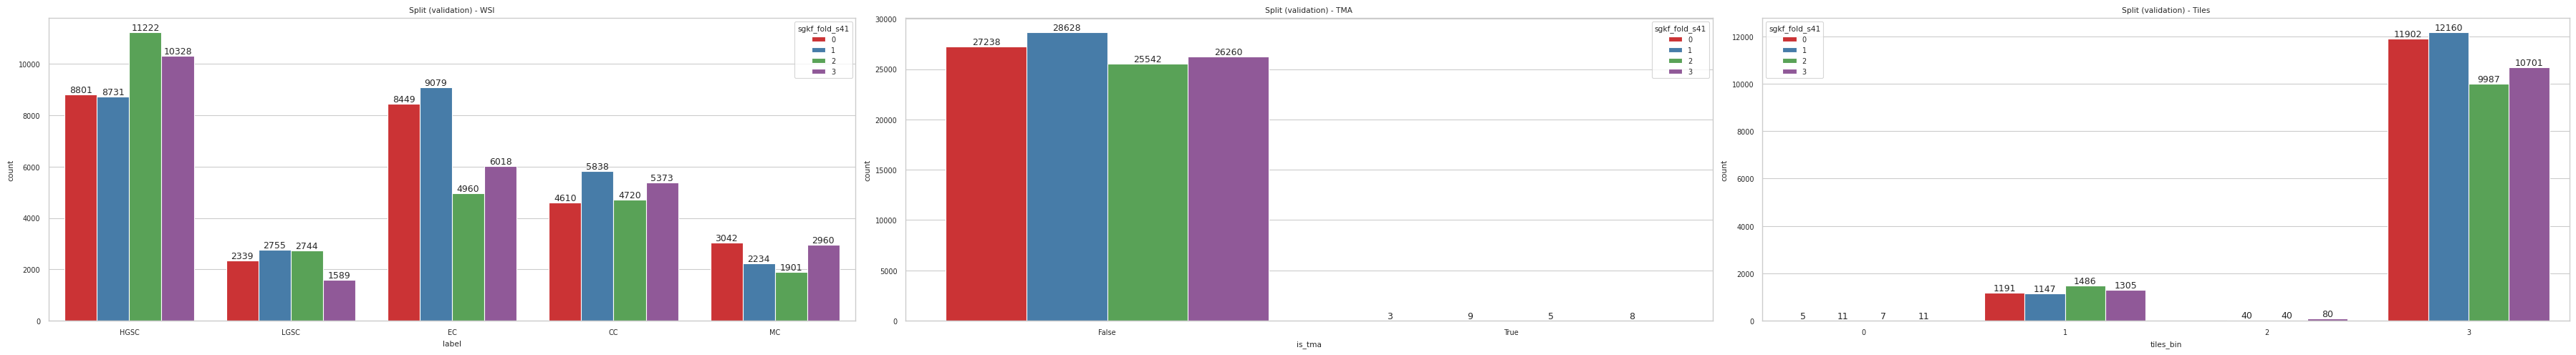

,image_id,label,image_width,image_height,is_tma,class,image_file,tiles,file,tiles_bin,sgkf_fold_s41
0,4,HGSC,23785,20008,False,0,./data/images/tma_x20_pyvips_FULL_AND_MASK_TUMORAL_0.5_OTSU_0.8_0.1_80_AUG/4/4_0.png,29,NaN,1,3
1,4,HGSC,23785,20008,False,0,./data/images/tma_x20_pyvips_FULL_AND_MASK_TUMORAL_0.5_OTSU_0.8_0.1_80_AUG/4/4_13.png,29,NaN,1,3
2,4,HGSC,23785,20008,False,0,./data/images/tma_x20_pyvips_FULL_AND_MASK_TUMORAL_0.5_OTSU_0.8_0.1_80_AUG/4/4_14.png,29,NaN,1,3
3,4,HGSC,23785,20008,False,0,./data/images/tma_x20_pyvips_FULL_AND_MASK_TUMORAL_0.5_OTSU_0.8_0.1_80_AUG/4/4_15.png,29,NaN,1,3
4,4,HGSC,23785,20008,False,0,./data/images/tma_x20_pyvips_FULL_AND_MASK_TUMORAL_0.5_OTSU_0.8_0.1_80_AUG/4/4_16.png,29,NaN,1,3


In [9]:
strat_cols = []
stratify = train_pd["class"].astype(str)

for col in strat_cols:
    stratify += "_" + train_pd[col].astype(str)

for seed_ in SEEDS:
    seed_everything(seed_)
    kf = StratifiedGroupKFold(shuffle=True, random_state=seed_, n_splits=FOLDS)
    graphs = []
    
    for fold, (idx_tr, idx_va) in enumerate(kf.split(X=train_pd, y=stratify, groups=train_pd["image_id"])):
        X_tr, X_va = train_pd.loc[idx_tr], train_pd.loc[idx_va]      
        print(seed_, fold, X_tr.shape, X_va.shape,
              X_tr["image_id"].nunique(), X_va["image_id"].nunique(),
              np.intersect1d(X_tr["image_id"].values, X_va["image_id"].values))
        train_pd.loc[idx_va, "sgkf_fold_s%d" % seed_] = fold
            
    train_pd["sgkf_fold_s%d" % seed_] = train_pd["sgkf_fold_s%d" % seed_].astype(np.int16)
    
    fig, ax = plt.subplots(1, 3, figsize=(36,5))
    d = sns.countplot(x="label", data=train_pd, hue="sgkf_fold_s%d" % seed_, ax=ax[0], palette = "Set1")
    for i in ax[0].containers:
        ax[0].bar_label(i,fmt='%d', fontsize=9)
    ax[0].set_title("Split (validation) - WSI")
    d = sns.countplot(x="is_tma", data=train_pd, hue="sgkf_fold_s%d" % seed_, ax=ax[1], palette = "Set1")
    for i in ax[1].containers:
        ax[1].bar_label(i,fmt='%d', fontsize=9)
    ax[1].set_title("Split (validation) - TMA")
    d = sns.countplot(x="tiles_bin", data=train_pd, hue="sgkf_fold_s%d" % seed_, ax=ax[2], palette = "Set1")
    for i in ax[2].containers:
        ax[2].bar_label(i,fmt='%d', fontsize=9)
    ax[2].set_title("Split (validation) - Tiles")    
    
    # plt.legend()
    plt.tight_layout()
    plt.show()
      
    print()

train_pd.to_parquet(os.path.join(DATA_HOME, "train_tma_with_%dfolds_%s.parquet" % (FOLDS, VERSION)), index=False)
train_pd.head()

In [10]:
seed_ = SEEDS[0]
images_pd = train_pd.groupby("image_id")[["image_width", "image_height", "label", "is_tma", "class", "tiles", "sgkf_fold_s41"]].first().reset_index()
images_pd

,image_id,image_width,image_height,label,is_tma,class,tiles,sgkf_fold_s41
0,4,23785,20008,HGSC,False,0,29,3
1,66,48871,48195,LGSC,False,1,60,0
2,91,3388,3388,HGSC,True,0,1,0
3,281,42309,15545,LGSC,False,1,14,3
4,286,37204,30020,EC,False,2,26,0
...,...,...,...,...,...,...,...,...
533,65022,53355,46675,LGSC,False,1,59,1
534,65094,55042,45080,MC,False,4,80,3
535,65300,75860,27503,HGSC,False,0,80,0
536,65371,42551,41800,HGSC,False,0,80,1


In [12]:
class Dataset(torch.utils.data.Dataset):

    def __init__(self, data_path, df, conf, subset='train', preprocess=None, augment=None, prepare=None):
        self.data_path = data_path
        self.df = df
        self.conf = conf
        self.subset = subset
        self.preprocess = preprocess
        self.augment = augment
        self.prepare = prepare
        
        self.margins = None
        if (self.subset == 'train') and (self.conf.loss_module == "subcenter_arcfaceadaptivemargin"):
            tmp = np.sqrt(1 / np.sqrt(self.df["class"].value_counts().sort_index().values))
            self.margins = (tmp - tmp.min()) / (tmp.max() - tmp.min()) * self.conf.loss_module_arcface_m_x + self.conf.loss_module_arcface_m_y
            self.margins = list(self.margins)  
    
    def read_image_(self, record_id):
        img = np.array(Image.open(record_id))
        return img

    def read_image(self, row):
        record_id = row["image_file"]
        return self.read_image_(record_id)

    def get_data(self, row, idx):
        img = self.read_image(row)

        sample = {
            'image': img,
            'weight': 1,
            "uid": row["image_id"],
        }

        # Optional preprocessing on RGB image (float)
        if self.preprocess:
            tmp = self.preprocess(image=sample['image'])
            sample['image'] = tmp["image"]  # Apply on full image

        # Optional augmentation on RGB image (float)
        if self.augment:
            tmp = self.augment(image=sample['image'])
            sample['image'] = tmp["image"]  # Apply on full image
                
        # Mandatory to feed model (normalization, convert to CHW)
        if (self.prepare) and (sample.get('image') is not None):
            tmp = self.prepare(image=sample['image'])
            sample['image'] = tmp["image"]  # Apply on full image

        sample["label"] = np.zeros(self.conf.num_classes, dtype=np.float32)
        if self.subset != "test":
            class_ = int(row["class"])
            label = np.zeros(self.conf.num_classes, dtype=np.float32)
            label[class_] = 1.
            sample["label"] = label

        feats = sample['image']
        labels = sample["label"]
        patient_ids = sample["uid"]

        return feats, labels, patient_ids

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        row = self.df.iloc[idx]
        sample = self.get_data(row, idx)
        return sample

In [13]:
def resize(new_size, conf, p=1.0):
    if conf.ar is None:
        return A.Compose([
            A.Resize(new_size, new_size, interpolation=cv2.INTER_LANCZOS4, p=1.0, always_apply=True),
        ], p=p)
    elif conf.ar == -1:
        return A.Compose([
            A.NoOp(),
        ], p=p)    


def normalizer(mean, std, max_pixel, p=1.0):
    return A.Compose([

        A.Normalize(mean=mean, std=std, max_pixel_value=max_pixel, p=1.0, always_apply=True),
        ToTensorV2(p=1.0, always_apply=True)

    ], p=p)

   
class Rotate90_270(A.RandomRotate90):
    def get_params(self):
        return {"factor": random.choice([1, 3])}


def medium_augmentation_train(conf, p=1.0):
    return A.Compose([

        # Flips/Rotate
        A.OneOf([
            A.HorizontalFlip(p=0.25),
            A.VerticalFlip(p=0.25),
            Rotate90_270(p=0.50)],
            p=0.75),

        # ShiftScaleRotate
        A.ShiftScaleRotate(shift_limit=(-0.10, 0.10), scale_limit=(-0.2,0.2), rotate_limit=(-30,30), interpolation=cv2.INTER_LINEAR, border_mode=0, value=(255,255,255), p=0.50),
        
        # Colors/Channels
        A.OneOf([
            A.RandomBrightnessContrast(brightness_limit=0.35, contrast_limit=0.5, brightness_by_max=True, p=0.16),
            A.RandomGamma(gamma_limit=(80, 120), p=0.16),
            A.HueSaturationValue(hue_shift_limit=30, sat_shift_limit=30, val_shift_limit=20, p=0.16),
            A.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1, p=0.16),
            A.ToGray(p=0.16),
            A.CLAHE(p=0.16),
        ], p=0.5),        
        
        # Blur/Noise
        A.OneOf([
            A.GaussianBlur(blur_limit=(3, 7), p=0.33),
            A.MotionBlur(blur_limit=(3, 5), p=0.33),
            A.GaussNoise(var_limit=(0, 50.0), mean=0, p=0.33),
        ], p=0.5),        

        # Cutout
        A.CoarseDropout(max_holes=2, max_height=config.imgsz//8, max_width=config.imgsz//8, fill_value=(255,255,255), p=0.25),
        
    ], p=p)



def no_augmentation_train(conf, p=1.0):
    return A.Compose([
        A.NoOp(),
    ], p=p)

In [14]:
# Some previews with augmentation
def display_preview(data_path, df, config, preprocess=None, augment=None, sampler=None, ROWS=20, COLS=3, max_batches=10, subset="train"):
    tmp_dataset = Dataset(data_path, df, config, subset=subset, preprocess=preprocess, augment=augment, prepare=None)
    print("tmp_dataset:", len(tmp_dataset))
    tmp_sampler = None # get_sampler(config.sampler, ds=tmp_dataset)
    tmp_batch_sampler = get_batch_sampler(config, ds=tmp_dataset, debug=True)
    print("Batch sampler", tmp_batch_sampler)   
    
    tmp_loader = torch.utils.data.DataLoader(tmp_dataset, batch_size=config.batch_size if tmp_batch_sampler is None else 1, num_workers=0, drop_last=False, pin_memory=False, sampler=tmp_sampler, batch_sampler=tmp_batch_sampler, shuffle=False) #1
    print("Loading")
    i = 0
    for tmp_batch in tmp_loader:
        images, labels, records = tmp_batch
        print(images.shape) if i == 0 else None

        k = 0
        K = 8
        labels_dict = {}
        
        for j, (img, label, record) in enumerate(zip(images, labels, records)):
            label = torch.argmax(label).item()
            labels_dict[label] = labels_dict[label] + 1 if labels_dict.get(label) is not None else 1
            if j == 0:
                print(img.shape, img.dtype, img.min(), img.max(), img.float().mean(), label, "uid", record)
            
            if k == 0:
                fig, ax = plt.subplots(1, K, figsize=(24, 5))
            
            d = ax[k].imshow(img.numpy())
            d = ax[k].set_title("%s: %s" % (record, label))
            d = ax[k].grid(False)
            k = k + 1
            
            if k == K:
                plt.tight_layout()
                plt.show()
                k = 0
                            
        print("labels_dict:", OrderedDict(sorted(labels_dict.items())))
        i = i + 1
        if i >= ROWS: break

In [15]:
class Config:
    
    version = "6.2.0"
    
    # Parameters
    seed=SEEDS[0]
    folds=FOLDS
    folds_seed=SEEDS[0]

    # Input image
    imgsz = 512
    ar = None
    center_crop = None
    crop_ratio = None
    
    # Backbone
    backbone = "tf_efficientnetv2_s_in21ft1k" # "tiny_vit_21m_512.dist_in22k_ft_in1k" 
    global_pool = 'avg'    
    # GeM
    gem_p = 3
    gem_p_trainable = True
    # ArcFace module
    loss_module = "subcenter_arcfaceadaptivemargin"
    # Adaptive Marging
    loss_module_margins = None # m is setup dynamically with training dataset    
    loss_module_arcface_m_x = 0.45
    loss_module_arcface_m_y = 0.05    
    loss_module_cosine_scale = 20 # (20 to 70) # s
    loss_module_k = 3
    fc_dim = 512 if len(loss_module) > 0 else None
  
    num_classes = len(CLASSES_MAP)
    # Pretrain
    pretrained = True
    max_pixel = 255.0
    IMG_MEAN = [0.485, 0.456, 0.406]
    IMG_STD = [0.229, 0.224, 0.225] 
 
    # Training
    epochs = 20
    batch_size = 32 
    val_batch_size = batch_size
    accumulate_grad_batches = 1    
    gradient_clip_val = None
    
    # Additional augmentations
    # Cut mix: Crop rectangle from another image in batch and paste it in image
    cutmix_prob = None # 0.20 # 0.5 # None
    cutmix_alpha = 1.0 
    # Mix 2 images within the same batch, try to improve generalization and reduce overfitting
    mixup_prob = None # 0.5 # None
    mixup_alpha = 0.2 # 1.0 # 0.2
    # Simulate TMA from tile
    tma_augmentation_train = None
    
    optimizer = 'AdamW'
    # You should decrease the learning rate by the square root of the increase in batch size. For example, if you increase the batch size by 4, you should decrease the learning rate by 2
    lr0 = 1e-4 #  if ("vit" in backbone) or ("coat" in backbone) or ("swin" in backbone) or ("dei" in backbone) else 1e-3 # 3e-5
    lrf = 0.0
    scheduler = "cos_lr" # "lw_cos_lr" # "cos_lr"
    warmup_epochs = 0 # 2
    
    # Generalization
    dropout = 0.0
    # https://github.com/hoya012/swa-tutorials-pytorch
    swa_lrs = None
    # https://docs.nvidia.com/deeplearning/nemo/user-guide/docs/en/stable/core/exp_manager.html
    # https://github.com/NVIDIA/NeMo/blob/main/nemo/collections/common/callbacks/ema.py
    ema = 0.999 # None
    save_top_k = 5
    
    # Regularization
    label_smoothing = 0.0 # Prevent overconfidence in label
    
    # Samplers
    sampler = None # "ImbalancedDatasetSampler" # None # "ImbalancedDatasetSampler"
    batch_sampler = "random" # "random" # "fixed" # None
    batch_sampler_alpha = 1.0
    
    # Hardware
    precision = "16-mixed"
    device = "gpu"
    deterministic = True
    num_workers = 6
    pruning = None

In [16]:
config = Config
seed_everything(config.seed, workers=True)

wandb_project = "TMA-V11"
models_home = "./models"
full_train = False
exclude_noisy = []
resume_fold = 0
train_home = IMAGES_HOME
save_weights_only = True
stage = "stage1"

preprocess_image = resize(config.imgsz, config, p=1.0) if config.imgsz is not None else None
image_augmentation_train = medium_augmentation_train(config, p=1.0)
prepare_feed = normalizer(config.IMG_MEAN, config.IMG_STD, config.max_pixel, p=1.0)

Seed set to 41


In [ ]:
for c in CLASSES_MAP_LIST:
    display_preview(IMAGES_HOME, train_pd[train_pd["class"] == c].sample(16), config, augment=image_augmentation_train, preprocess=preprocess_image, ROWS=2)

In [19]:
display_preview(IMAGES_HOME, train_pd[(train_pd["is_tma"] != True)].sample(16), config, augment=None, preprocess=preprocess_image, ROWS=2, subset="valid")

tmp_dataset: 16
0 = 5
1 = 1
2 = 4
3 = 5
4 = 1
Batch sampler <ubc.training.samplers.WeightedRandomBatchSampler object at 0x7fd64c2ec7f0>
Loading


In [20]:
FULL_TRAIN = False # True

In [ ]:
for fold_ in range(config.folds):
    if fold_ < resume_fold:
        continue

    x_valid = train_pd[train_pd["sgkf_fold_s%d" % config.folds_seed] == fold_]
    x_train = train_pd[train_pd["sgkf_fold_s%d" % config.folds_seed] != fold_]
    x_valid_cleaned = x_valid
    x_train_cleaned = x_train        

    print("Valid/Train:", x_valid.shape, x_valid_cleaned.shape, x_train.shape, x_train_cleaned.shape)

    train_dataset = Dataset(train_home, x_train_cleaned, config, subset="train", preprocess=preprocess_image,
                            augment=image_augmentation_train, prepare=prepare_feed)
    valid_dataset = Dataset(train_home, x_valid_cleaned, config, subset="valid", preprocess=preprocess_image,
                            augment=None, prepare=prepare_feed)

    train_sampler = get_sampler(config.sampler, ds=train_dataset)
    print("Train sampler", train_sampler)

    train_batch_sampler = get_batch_sampler(config, ds=train_dataset)
    print("Train batch sampler", train_batch_sampler)

    config.loss_module_margins = train_dataset.margins
    print("Train loss margins", config.loss_module_margins)    

    train_dataloader = data.DataLoader(train_dataset,
                                       batch_size=config.batch_size if train_batch_sampler is None else 1,
                                       sampler=train_sampler, batch_sampler=train_batch_sampler, drop_last=False,
                                       num_workers=config.num_workers, shuffle=True if (
                    (train_sampler is None) and (train_batch_sampler is None)) else False, pin_memory=True)
    valid_dataloader = data.DataLoader(valid_dataset, batch_size=config.val_batch_size, drop_last=False,
                                       num_workers=config.num_workers, pin_memory=True)

    model = UBCModel(config)

    model_path = "classifier_%s_%s_%s/seed%s/%s/%s" % (
    config.imgsz, config.backbone, config.version, config.seed, "fold%d" % fold_, stage)

    resume_ckpt_path = None
            
    default_root_dir = os.path.join(models_home, model_path)
    os.makedirs(default_root_dir, exist_ok=True)
    d = save_config(config, os.path.join(default_root_dir, "config.json"))

    logger_wandb = None
    if wandb_project is not None:
        logger_wandb = WandbLogger(project=wandb_project, name=model_path.replace("/", "_"))
    logger_csv = CSVLogger("./logs", name=model_path.replace("/", "_"))

    lr_monitor = LearningRateMonitor(logging_interval='epoch')
    checkpoint_callback = ModelCheckpoint(dirpath=default_root_dir, monitor="val_balanced_accuracy", mode='max',
                                          filename='best_{epoch}-{val_balanced_accuracy:.4f}', save_top_k=config.save_top_k,
                                          save_last=True, save_weights_only=save_weights_only) 

    callbacks = [lr_monitor]

    if config.ema is not None:
        print("EMA enabled:", config.ema)
        ema = EMA(config.ema)
        callbacks.extend([ema])
        checkpoint_callback = NeMoModelCheckpoint(dirpath=default_root_dir, monitor="val_balanced_accuracy", mode='max',
                                                  filename='best_{epoch}-{val_balanced_accuracy:.4f}',
                                                  save_top_k=config.save_top_k, save_last=True,
                                                  save_nemo_on_train_end=False, save_weights_only=save_weights_only)

    callbacks.extend([checkpoint_callback])

    if config.swa_lrs is not None:
        print("SWA enabled")
        swa = StochasticWeightAveraging(swa_lrs=config.swa_lrs)
        callbacks.extend([swa])

    print()
    trainer = L.Trainer(
        default_root_dir=default_root_dir,
        max_epochs=config.epochs,
        accelerator=config.device,
        accumulate_grad_batches=config.accumulate_grad_batches,
        gradient_clip_val=config.gradient_clip_val,
        deterministic=config.deterministic,
        precision=config.precision,
        logger=logger_wandb if logger_wandb is not None else logger_csv,
        callbacks=callbacks,
        check_val_every_n_epoch=1,
        enable_progress_bar=True,
    )

    trainer.fit(model, train_dataloader, valid_dataloader, ckpt_path=resume_ckpt_path) # ckpt_path="some/path/to/my_checkpoint.ckpt" # Resume

    if logger_wandb is not None:
        wandb.finish()

    # break